# Homework 1 — Task 2: Dataset and Advanced EDA

**Goal:** Choose a public dataset (≥10 features), run advanced EDA, check multicollinearity using VIF, and create advanced relationship visualizations.

Dataset used below: **UCI Bank Marketing** (binary target `y`: term deposit subscribed yes/no). The raw dataset has **16 input features** plus the target.

- Dataset page: https://archive.ics.uci.edu/dataset/222/bank+marketing
- We download the `bank-full.csv` file from the dataset ZIP and load it with `sep=';'`.


## 2.1 Install & import libraries

In [ ]:
!pip -q install pandas numpy matplotlib seaborn statsmodels scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set_context("notebook")


## 2.2 Download and load the dataset


In [21]:
!wget -q -O bank_marketing.zip https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
!unzip -o bank_marketing.zip -d .
!unzip -o bank.zip


import pandas as pd

df = pd.read_csv("bank-full.csv", sep=";")

print("Shape:", df.shape)
df.head()


Archive:  bank_marketing.zip
 extracting: ./bank.zip              
 extracting: ./bank-additional.zip   
unzip:  cannot find or open bank.zipd, bank.zipd.zip or bank.zipd.ZIP.
Shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## 2.3 Basic inspection (types, missing values, class balance)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [23]:
# Check missing values
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0].head(20)

,0


In [24]:
# Count 'unknown' occurrences in categorical columns
cat_cols = df.select_dtypes(include="object").columns
unknown_counts = {c: (df[c].astype(str).str.lower() == "unknown").sum() for c in cat_cols}
pd.Series(unknown_counts).sort_values(ascending=False).head(20)

,0
poutcome,36959
contact,13020
education,1857
job,288
marital,0
default,0
loan,0
housing,0
month,0
y,0


### Target variable
The target column is `y` (yes/no). map it to binary 1/0 for later modeling, but for EDA inspect counts first.

In [25]:
df["y"].value_counts()

,count
y,
no,39922
yes,5289


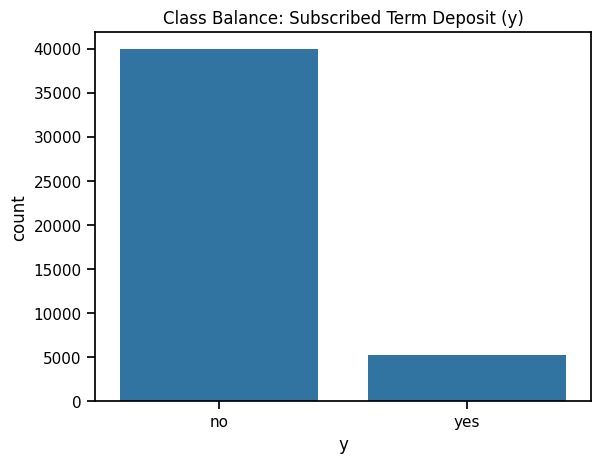

In [26]:
plt.figure()
sns.countplot(data=df, x="y")
plt.title("Class Balance: Subscribed Term Deposit (y)")
plt.show()


## 2.4 Separate features by type
identify numeric vs categorical columns.

In [27]:
target_col = "y"
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols + [target_col]]

numeric_cols, categorical_cols, len(numeric_cols), len(categorical_cols)

(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'],
 ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'poutcome'],
 7,
 9)

## 2.5 Univariate EDA (numeric distributions)
visualize distributions and look for skew/outliers.

In [28]:
df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


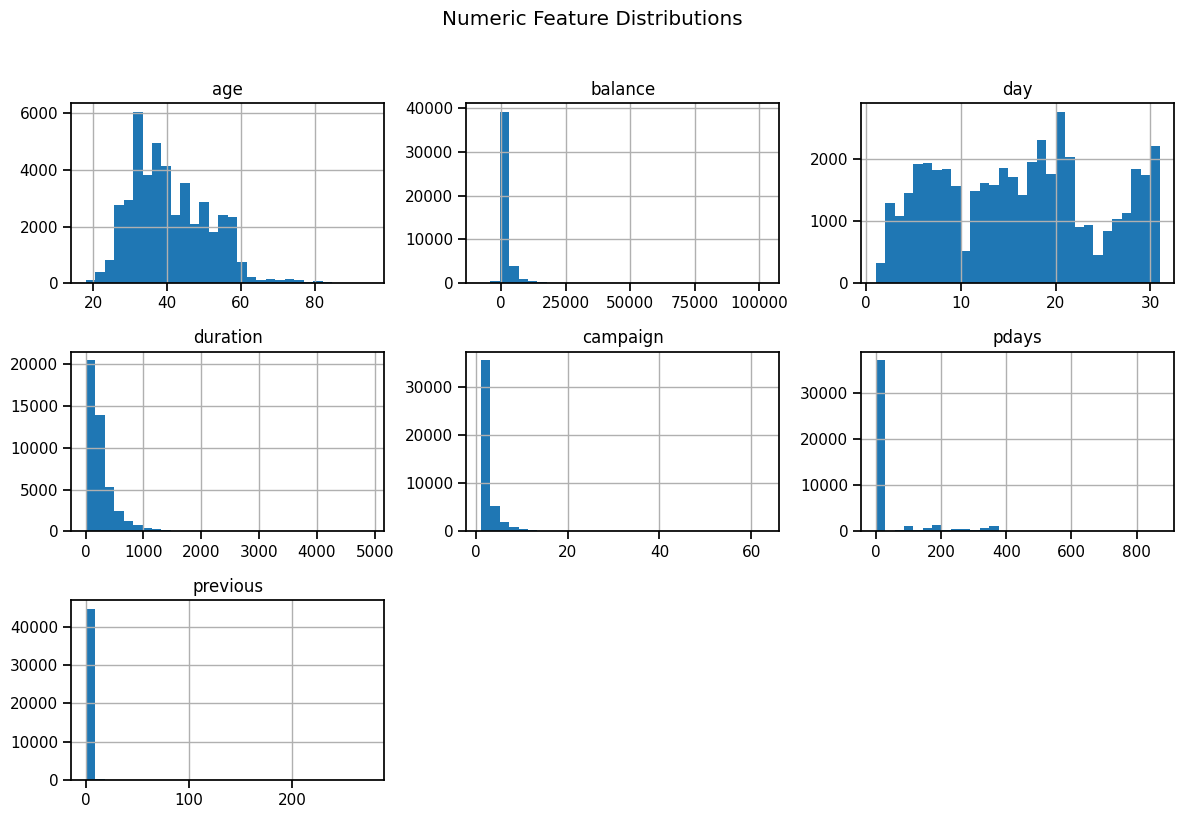

In [29]:
# Histograms for numeric variables
df[numeric_cols].hist(bins=30, figsize=(12, 8))
plt.suptitle("Numeric Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()


## 2.6 Bivariate EDA (numeric correlations)
A correlation heatmap helps identify potential multicollinearity (high absolute correlations).

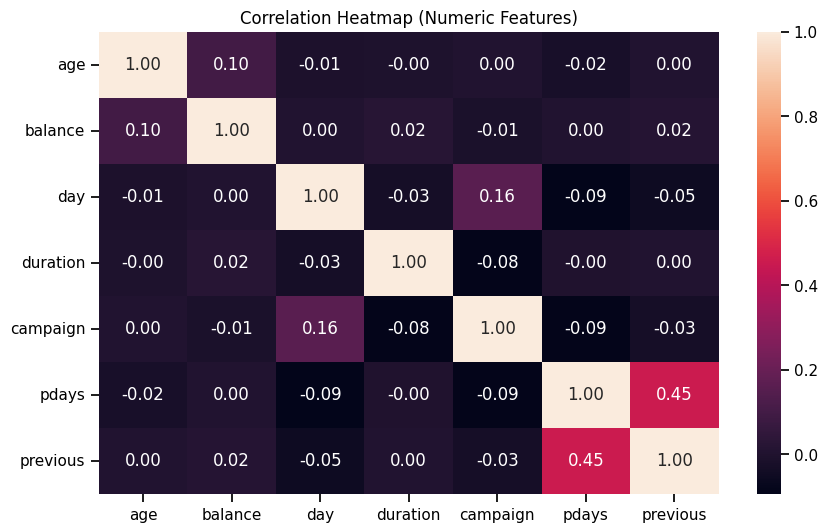

In [30]:
corr = df[numeric_cols].corr(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


## 2.7 Multicollinearity with VIF (Variance Inflation Factor)

**Requirement (Task 2.2):** Use VIF to identify highly correlated variables and demonstrate steps to handle them.


In [31]:
# Prepare numeric matrix (scaled)
X_num = df[numeric_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# Compute VIF for each numeric feature
vif_df = pd.DataFrame({
    "feature": numeric_cols,
    "VIF": [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
}).sort_values("VIF", ascending=False)

vif_df

,feature,VIF
5,pdays,1.276189
6,previous,1.261640
4,campaign,1.040116
2,day,1.034433
1,balance,1.010681
0,age,1.010613
3,duration,1.008075


### Handling high VIF features


In [32]:
def reduce_multicollinearity_vif(X: pd.DataFrame, threshold: float = 10.0):
    """Iteratively drop columns with VIF > threshold.
    Returns: (kept_columns, vif_table_history)
    """
    cols = X.columns.tolist()
    history = []
    scaler = StandardScaler()

    while True:
        X_scaled = scaler.fit_transform(X[cols])
        vifs = [variance_inflation_factor(X_scaled, i) for i in range(len(cols))]
        vif_table = pd.DataFrame({"feature": cols, "VIF": vifs}).sort_values("VIF", ascending=False)
        history.append(vif_table)

        max_vif = vif_table["VIF"].iloc[0]
        max_feat = vif_table["feature"].iloc[0]

        if max_vif <= threshold or len(cols) <= 2:
            break

        # Drop the worst feature
        cols.remove(max_feat)

    return cols, history

kept_cols, vif_history = reduce_multicollinearity_vif(df[numeric_cols], threshold=10.0)
print("Original numeric cols:", numeric_cols)
print("Kept numeric cols after VIF reduction:", kept_cols)

# Show final VIF table
vif_history[-1]

Original numeric cols: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Kept numeric cols after VIF reduction: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


,feature,VIF
5,pdays,1.276189
6,previous,1.261640
4,campaign,1.040116
2,day,1.034433
1,balance,1.010681
0,age,1.010613
3,duration,1.008075


## 2.8 Advanced visualizations (Task 2.3)
**Requirement:** At least two advanced visualization techniques.

1) **Pair plot with KDE** on a subset of numeric features
2) **Clustered correlation heatmap** (hierarchical clustering) using `seaborn.clustermap`.


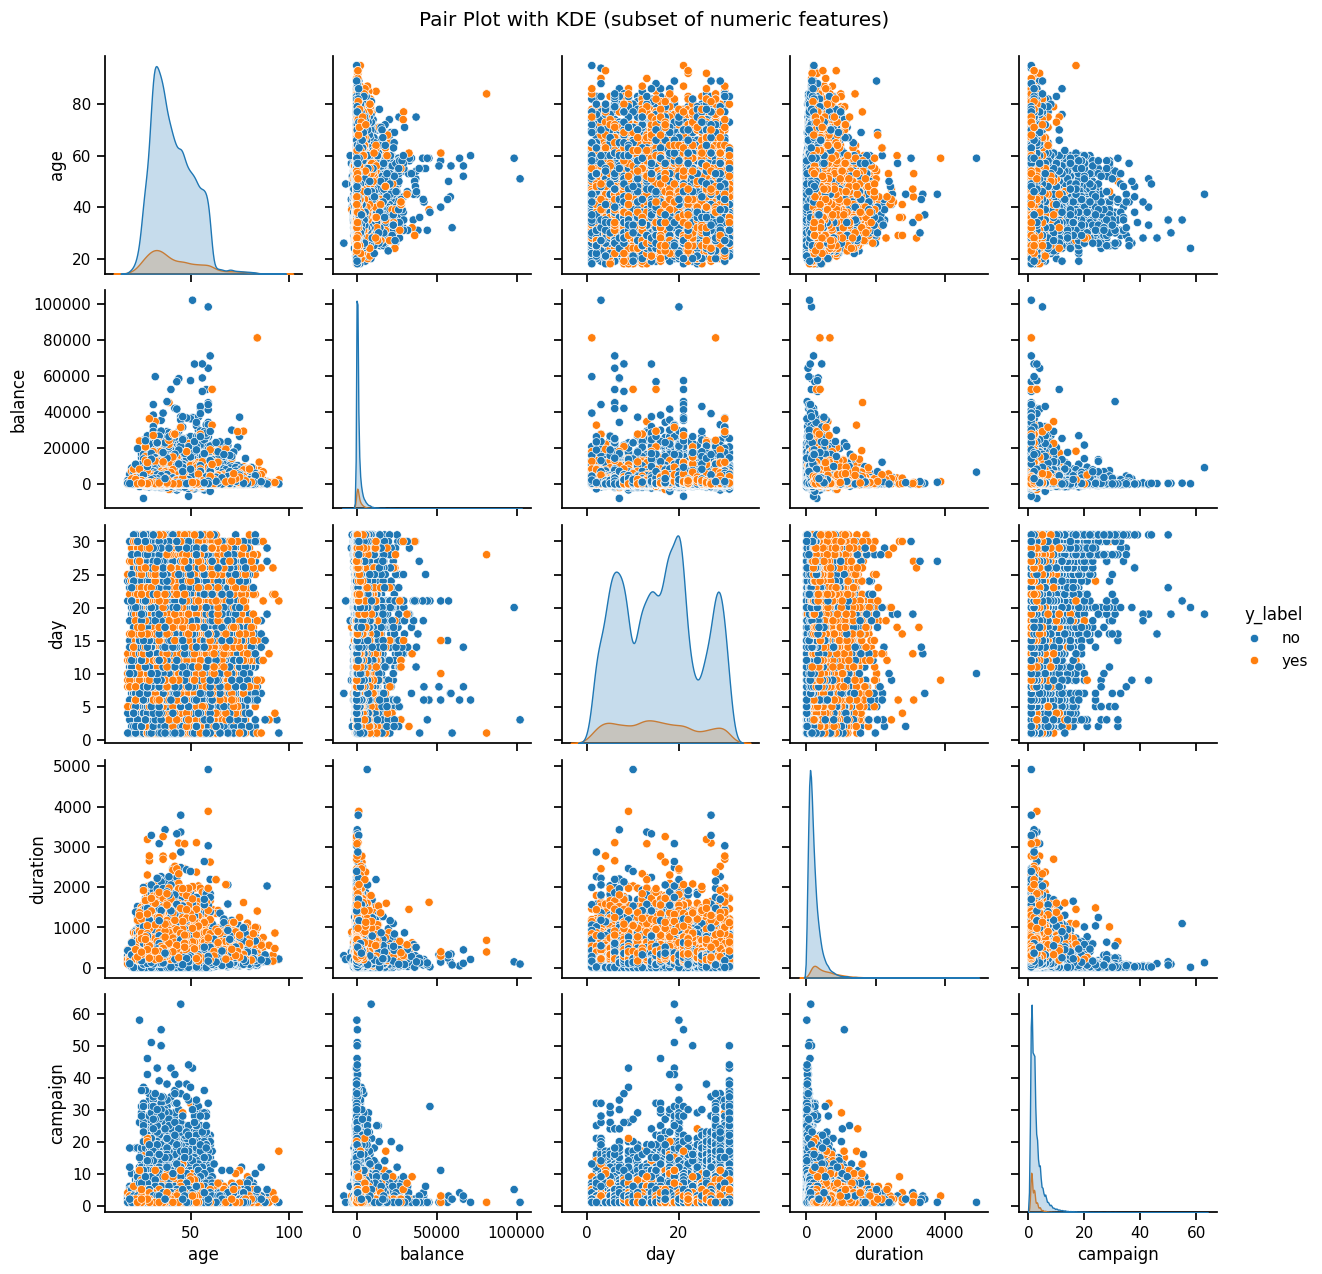

In [34]:
# Choose a small subset of numeric features for pairplot (you can adjust)
pair_cols = numeric_cols[:5]  # first 5 numeric columns
df_pair = df[pair_cols + ["y"]].copy()

# Map y to a cleaner label for plotting
df_pair["y_label"] = df["y"].map({"yes": "yes", "no": "no"})

sns.pairplot(df_pair.drop(columns=["y"]), hue="y_label", diag_kind="kde")
plt.suptitle("Pair Plot with KDE (subset of numeric features)", y=1.02)
plt.show()


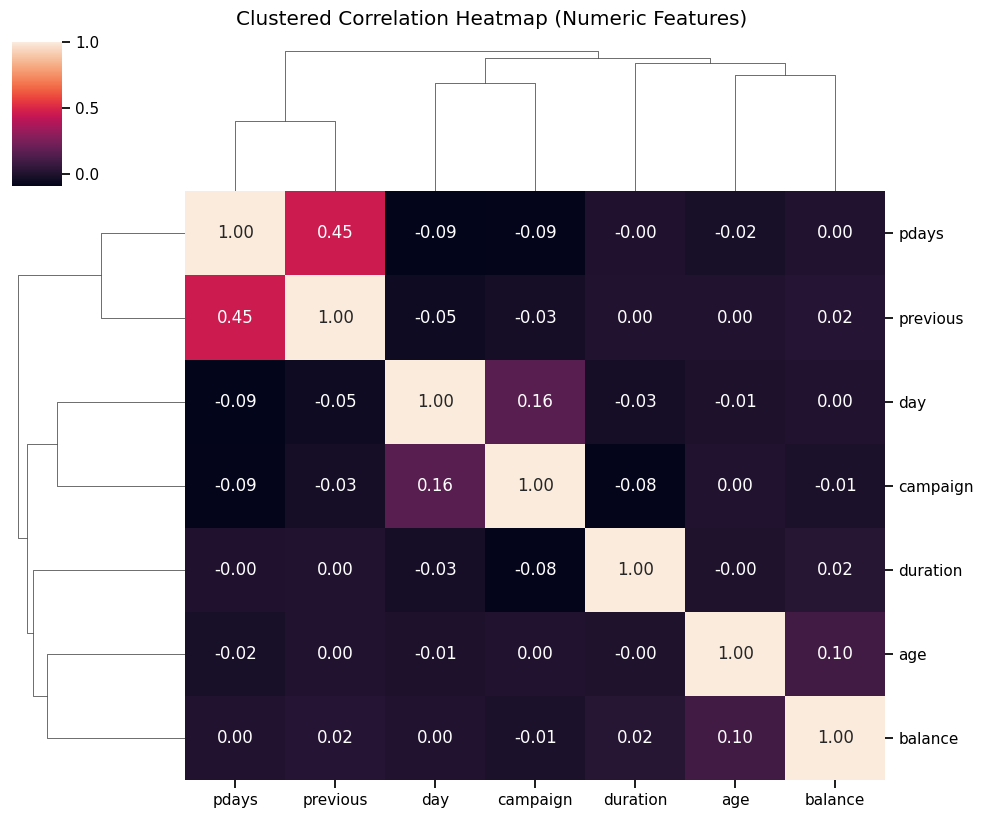

In [35]:
# Clustered correlation heatmap (hierarchical clustering)
corr_num = df[numeric_cols].corr()

sns.clustermap(corr_num, annot=True, fmt=".2f", figsize=(10, 8))
plt.suptitle("Clustered Correlation Heatmap (Numeric Features)", y=1.02)
plt.show()
